# Analysis of Competitive Rubik's Cube Solving
### Liam Chen - CMSC320 Final Tutorial

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Scramble.svg/1920px-Scramble.svg.png" alt="Image of a Rubik's Cube" width=100 height=100/>

## Introduction

The Rubik's Cube is a puzzle that has captured the attention and excitement of people around the world for decades. Once seen as a nearly impossible task, the Rubik's cube has evolved over time into a fun challenge that after dedicated practice, can be solved in mere seconds. There is a whole world of competitive Rubik's Cube solvers who compete with each other to see who can solve what puzzles, in what different ways, the fastest. 

In this tutorial, we will explore and analyze data from the world of competitive Rubik's Cube solving. Through this data analysis, we aim to gain more insight into questions regarding the current status, and future of cubing as an activity.  

> There is some terminology in this tutorial that may be unfamiliar. They will make more sense in the context they are given, but here is a basic glossary of terms: 
> - **WCA** - aka the [World Cube Association](https://worldcubeassociation.org), the governing body that organizes, oversees, and regulates Rubik's Cube competitions all over the world
> - **cubing** - the activity/hobby/sport of solving Rubik's cubes
> - **3x3** - the standard 3x3x3 [Rubik's Cube](https://en.wikipedia.org/wiki/Rubik%27s_Cube)
> - **event** - aside from the standard 3x3, there are many different [events](https://en.wikipedia.org/wiki/World_Cube_Association#Events) in which competitors compete in, including 4x4, 3x3 blindfolded, and many more
> - **solve** - a unit of measurement representing the process of solving a Rubik's Cube (ie. *"that solve was really fast!"*)
> - **single** - the time of one solve. Usually used in contrast to **average** (ie. *"I got a 9.50 single today!"*)
> - **average** - The arithmetic mean of the middle 3 solves out of 5 (ie. out of 5 solves, the slowest and fastest solves are disregarded and the rest are averaged, done to try to eliminate luck as a factor). In some less common contexts **average** will be the arithmetic mean. 

## Data Collection & Setup

The [World Cube Association](https://www.worldcubeassociation.org) conveniently provides an exportable `SQL` file of the entire database. The most recent export can be obtained on [this page](https://www.worldcubeassociation.org/results/misc/export.html), however this tutorial uses the **May 04 2023 6:02GMT export** of the database ([download it here](https://www.worldcubeassociation.org/results/misc/WCA_export.sql.zip)). Due to the frequently udpating nature of the WCA database, it was necessary to decide on only one version to use in order to facilitate development of this tutorial. 

> Due to Github's restrictions on file size, we were not able to include the WCA database in this repository. If you want to follow along with this tutorial exactly, you must download the database at the link provided above. 

Aside from the required Python libraries, this tutorial also requires [MySQL Server](https://dev.mysql.com/downloads/mysql/) in order to follow along. This tutorial will not detail how to get MySQL Server installed and running, however the process is fairly straightfoward and there are many [online guides](https://dev.mysql.com/doc/mysql-installation-excerpt/5.7/en/) that can help.

Clone this repository [here](https://github.com/chen2li3an1/chen2li3an1.github.io), and navigate into the cloned repository. Install all the required Python libraries by running the cell below, or by running the command (without the `%` symbol) in your terminal. 

> This setup portion assumes basic familiarity with the command line and git repositories. For more information, check out the recommended readings: [First steps with git](https://www.earthdatascience.org/workshops/intro-version-control-git/basic-git-commands/), [Git Basics](https://git-scm.com/book/en/v2/Git-Basics-Getting-a-Git-Repository), [Command line crash course](https://developer.mozilla.org/en-US/docs/Learn/Tools_and_testing/Understanding_client-side_tools/Command_line), [Command line basics](https://www.theodinproject.com/lessons/foundations-command-line-basics)

In [ ]:
%pip install requirements.txt

In [21]:
# imports
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
from mysql.connector import connect, Error
from sklearn import svm
from sklearn.naive_bayes            import GaussianNB
from sklearn.svm                    import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.formula.api as sm

# surpressing the "pandas only supports SQLAlchemy warning"
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)  
# full warning: 
# """ UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. 
# Other DBAPI2 objects are not tested. Please consider using SQLAlchemy. """


Run the cell below and input your MySQL Server username and password (they are kept in memory until the kernel is stopped). Depending on how you configured MySQL Server, you may not need a username nor a password. If this is the case, then you can press enter twice to skip both fields. 
> Most users can run  ``` mysql -u root``` in their terminal to log into MySQL Server. If you can do this successfully, that means that you can press enter twice to skip both fields after running the cell below.

In [4]:
mysql_username = input("Enter username: ")
mysql_password = getpass("Enter password: ")

Now, we can establish a connection with MySQL Server by using the `mysql-connector-python` library. First we create a connection object, use that to create a cursor object, then we execute a query to create an empty database called `wca`. Lastly, we close the connection and the cursor.

In [19]:
# establish connection with MySQL Server
connection = connect(
    host="localhost",
    user=mysql_username,
    password=mysql_password
)
qry_create_db = "CREATE DATABASE wca"   # query to create an empty database called "wca"
cursor = connection.cursor()            # create the cursor
cursor.execute(qry_create_db)           # execute the query
cursor.close()                          # close the cursor
connection.close()                      # close the connection

Now, we use our downloaded SQL file to actually create the database. If you have set up MySQL Server in the default configuration and are using the same [SQL file](https://www.worldcubeassociation.org/results/misc/WCA_export.sql.zip) as I am, run the following cell (or run it in your terminal (without the `!` symbol)). 

> If you have configured a specific MySQL Server username/password, or if you are using a different version of the SQL file downloaded from the WCA, then run the following command in your terminal:
> ```console
> mysql -u username -p password wca < filename.sql
> ```
> replacing `username` and `password` with your username and password (respectively) and replacing `filename.sql` with the [path to the] SQL file you want to use. 

Note that the WCA database is fairly large, so don't be alarmed if this command takes a few minutes to execute.

In [20]:
!mysql -u root wca < WCA_export192_20230504T040001Z/WCA_export.sql

## Queries

Now we can finally get started! Let's run a basic query on the database: we want to see the top fifty [3x3](https://en.wikipedia.org/wiki/Rubik%27s_Cube) solvers in the world. 

We construct the appropriate SQL query, establish the connection to the database, and use the `pandas` function `read_sql` in order to execute this query and retrieve the result as a dataframe.

In [50]:
# establish the connection to our database "wca"
connection = connect(host="localhost", user=mysql_username, password=mysql_password, database="wca")

qry_top_50 = """
                SELECT * 
                FROM RanksSingle 
                WHERE eventID='333'     
                LIMIT 50 ;
            """

# execute the query and store the result in a dataframe
df_top_50 = pd.read_sql(qry_top_50, con=connection)
display(df_top_50)

connection.close() # close the connection

,personId,eventId,best,worldRank,continentRank,countryRank
0,2015DUYU01,333,347,1,1,1
1,2012PARK03,333,363,2,1,1
2,2016JONE04,333,388,3,1,1
3,2017KIMM01,333,389,4,2,2
4,2019WANY36,333,390,5,2,2
5,2017GARR05,333,395,6,3,3
6,2016KOLA02,333,397,7,1,1
7,2017SIAU02,333,403,8,4,4
8,2017XURU04,333,406,9,3,3
9,2016INAB01,333,413,10,5,5


Interpreting the above results, we can see the top fifty 3x3 solvers in the world, ranked by their best single. We can see their `personID` (aka their WCA ID, which is a unique identifier for every WCA competitor), their best single result (measured in centiseconds), their world ranking, continental ranking, and national ranking (all based on their best single time). The `eventId` being `333` means that these results are in the 3x3 Rubik's Cube event. 
We can see that the best 3x3 single result ever is 3.47 seconds, held by 2015DUYU01.

Seeing the results are great, but with only the WCA ID of each competitor, we don't know much about them. What if we want to see their names, what country they are from, and their gender? 

In [51]:
# using the Python `with` statement for easier resource management
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_top_50_extra = """
                    SELECT Persons.id, Persons.name, Persons.countryId, Persons.gender, RanksSingle.best, RanksSingle.worldRank
                    FROM RanksSingle
                    INNER JOIN Persons ON RanksSingle.personID=Persons.id
                    WHERE RanksSingle.eventID='333'
                    ORDER BY RanksSingle.best
                    LIMIT 50 ;
                """

    df_top_50_extra = pd.read_sql(qry_top_50_extra, con=connection)
    display(df_top_50_extra)

,id,name,countryId,gender,best,worldRank
0,2015DUYU01,Yusheng Du (杜宇生),China,m,347,1
1,2012PARK03,Max Park,USA,m,363,2
2,2016JONE04,Jode Brewster,Australia,m,388,3
3,2017KIMM01,Asher Kim-Magierek,USA,m,389,4
4,2019WANY36,Yiheng Wang (王艺衡),China,m,390,5
5,2017GARR05,Luke Garrett,USA,m,395,6
6,2016KOLA02,Tymon Kolasiński,Poland,m,397,7
7,2017SIAU02,Max Siauw,USA,m,403,8
8,2017XURU04,Ruihang Xu (许瑞航),China,m,406,9
9,2016INAB01,Matty Hiroto Inaba,USA,m,413,10


Looks pretty good! If we compare this dataframe (`df_top_50_extra`) with the previous one (`df_top_50`), we notice some slight discrepancies. Notice how `df_top_50` ends with 2010BRAD01's result of 4.76 seconds, but `df_top_50_extra` ends with 2019SICH01's result of 4.75 seconds. This would suggest that we have an extra value in our current dataframe (`df_top_50_extra`) which is pushing everything down (thus some slower results are pushed out of the top 50). 

Why does this discrepancy exist when all we are doing is adding extra information like competitor name and country? If we look closely at (`df_top_50_extra`), we can see an anomaly...

In [44]:
display(df_top_50_extra[28:30])

,id,name,countryId,gender,best,worldRank
28,2015LARS04,Kim Roger Høyland Larsen,Norway,m,453,29
29,2015LARS04,Kim Roger Haraldsen,Norway,m,453,29


We have a duplicate! These two results have a similar name, as well as the exact same `countryId`, `gender`, `best`, and `worldRank`. This would all be fine (albeit suspicious and unlikely) if not for the fact that the `id` field is the same. WCA IDs are supposed to be unique identifiers for competitors, and we queried for top fifty 3x3 competitors in the world, so no competitor should appear twice in our dataframe. 

The reason this happens is because the WCA allows competitors to change certain data about themeslves, such as in the case that a competitor moves countries, or legally changes their name. When such a change happens, the competitor's record in the `Persons` field is not updated, but rather a new record is created with the altered data. We can see this by querying the results table for 2015LARS04:

In [52]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_2015lars04 = """
                    SELECT * 
                    FROM Persons
                    WHERE id = '2015LARS04' ;
                """
    df_2015lars04 = pd.read_sql(qry_2015lars04, con=connection)
    display(df_2015lars04)

,id,subid,name,countryId,gender
0,2015LARS04,1,Kim Roger Haraldsen,Norway,m
1,2015LARS04,2,Kim Roger Høyland Larsen,Norway,m


Here we see two records with the same `id` of 2015LARS04. `name` is the field that differs. As mentioned previously, this represents the same competitor, before and after a legal name change. The `subid` field is important here, because it indicates that their `Persons` record has been changed before. The current version is represented by a `subid` of 1. 

Knowing this, we can alter our query for the top fifty 3x3 solvers including name, country, and gender to disallow duplicate WCA IDs. We can do this by adding `Persons.subid=1` to the `WHERE` clause. 

In [58]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_top_50_extra = """
                    SELECT Persons.id, Persons.name, Persons.countryId, Persons.gender, RanksSingle.best, RanksSingle.worldRank
                    FROM RanksSingle
                    INNER JOIN Persons ON RanksSingle.personID=Persons.id
                    WHERE RanksSingle.eventID='333' 
                        AND Persons.subid=1
                    ORDER BY RanksSingle.best
                    LIMIT 50 ;
                """

    df_top_50_extra = pd.read_sql(qry_top_50_extra, con=connection)
    display(df_top_50_extra)

,id,name,countryId,gender,best,worldRank
0,2015DUYU01,Yusheng Du (杜宇生),China,m,347,1
1,2012PARK03,Max Park,USA,m,363,2
2,2016JONE04,Jode Brewster,Australia,m,388,3
3,2017KIMM01,Asher Kim-Magierek,USA,m,389,4
4,2019WANY36,Yiheng Wang (王艺衡),China,m,390,5
5,2017GARR05,Luke Garrett,USA,m,395,6
6,2016KOLA02,Tymon Kolasiński,Poland,m,397,7
7,2017SIAU02,Max Siauw,USA,m,403,8
8,2017XURU04,Ruihang Xu (许瑞航),China,m,406,9
9,2016INAB01,Matty Hiroto Inaba,USA,m,413,10


No more duplicates! 

Let's run some more involved queries to get more familiar with the database schema. What if we wanted to see the top rankings in other events, such as the [4x4 cube](https://en.wikipedia.org/wiki/Rubik%27s_Revenge), ranked by competitor's best [average](https://www.worldcubeassociation.org/regulations/#9f8) of five solves? 

In [63]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    # querying the RanksAverage table instead of RanksSingle table 
    # in order to get competitor's best WCA average of five solves in a round
    qry_top_20_444_avg = """
                    SELECT Persons.id, Persons.name, Persons.countryId, Persons.gender, RanksAverage.best, RanksAverage.worldRank
                    FROM RanksAverage
                    INNER JOIN Persons ON RanksAverage.personID=Persons.id
                    WHERE RanksAverage.eventID='444' 
                        AND Persons.subid=1
                    ORDER BY RanksAverage.best
                    LIMIT 20 ;
                """
    df_top_20_444_avg = pd.read_sql(qry_top_20_444_avg, con=connection)
    display(df_top_20_444_avg)

,id,name,countryId,gender,best,worldRank
0,2012PARK03,Max Park,USA,m,1938,1
1,2010WEYE02,Sebastian Weyer,Germany,m,2146,2
2,2009ZEMD01,Feliks Zemdegs,Australia,m,2157,3
3,2013NAHM01,Seung Hyuk Nahm (남승혁),Korea,m,2167,4
4,2016KOLA02,Tymon Kolasiński,Poland,m,2171,5
5,2016INAB01,Matty Hiroto Inaba,USA,m,2254,6
6,2015WANG09,Kai-Wen Wang (王楷文),Taiwan,m,2261,7
7,2012PONC02,Patrick Ponce,USA,m,2307,8
8,2016NUNE11,Brandon Nunez,USA,m,2361,9
9,2017RAND06,Ari Randers-Pehrson,USA,m,2367,10


How about the top twenty female rankings by [average](https://www.worldcubeassociation.org/regulations/#9f8) in the [Square-1](https://en.wikipedia.org/wiki/Square-1_(puzzle)) event? 

In [66]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_top_20_sq1_avg = """
                    SELECT Persons.id, Persons.name, Persons.countryId, Persons.gender, RanksAverage.best, RanksAverage.worldRank
                    FROM RanksAverage
                    INNER JOIN Persons ON RanksAverage.personID=Persons.id
                    WHERE RanksAverage.eventID='sq1' 
                        AND Persons.subid=1
                        AND Persons.gender='f'
                    ORDER BY RanksAverage.best
                    LIMIT 20 ;
                """
    df_top_20_sq1_avg = pd.read_sql(qry_top_20_sq1_avg, con=connection)
    display(df_top_20_sq1_avg)

,id,name,countryId,gender,best,worldRank
0,2016CHEN53,Anshu Chennuru,USA,f,668,15
1,2013KATO01,Eva Kato,USA,f,770,52
2,2017MELL02,Laura Mellier,Switzerland,f,856,93
3,2014CHAN23,Sophie Chan,USA,f,911,132
4,2017PABI01,Magdalena Pabisz,Poland,f,916,140
5,2016SINN01,Eleanor Sinnott,United Kingdom,f,964,179
6,2013KLEI03,Livia Kleiner,USA,f,982,196
7,2015CALD02,Kymberlyn Calderon,USA,f,991,205
8,2015JOIN01,Kyra Joiner,USA,f,1055,267
9,2022THUY01,Lê Phương Thùy,Vietnam,f,1068,282


How about ranking countries by number of WCA competitions that have occurred in that country in 2022?

In [91]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_2022_country_comps = """
                        SELECT countryId, COUNT(countryId) as number_of_comps
                        FROM Competitions
                        WHERE Competitions.year = 2022
                        GROUP BY countryId
                        ORDER BY number_of_comps DESC
                        LIMIT 20
                    """
    df_2022_country_comps = pd.read_sql(qry_2022_country_comps, con=connection)
    display(df_2022_country_comps)

,countryId,number_of_comps
0,USA,280
1,Australia,66
2,Poland,46
3,India,45
4,Canada,32
5,United Kingdom,32
6,Brazil,32
7,Spain,29
8,France,28
9,Colombia,24


## The Best Cuber?

We have seen the results of many queries dealing with rankings in specific events. But a question that WCA competitors and fans have asked for ages remains: who is the best all-around cuber? A competitor like [Max Park](https://www.worldcubeassociation.org/persons/2012PARK03) for example, is at the very top of the rankings in NxN events (where N=[3,7]) but has a very poor Square-1 ranking (ranked 12,063rd in the world for Square-1 single), not to mention does not even compete in any of the other 11 events. How would we go about determining who is the best all-around competitor; the person who is by some people's definition, the "best cuber in the world"?

One option to do this would simply be to sum every competitor's world rankings. The person with the lowest sum would then be the best all-around cuber. In order to account for a competitor who does not compete in a certain event, we simply use (the number of unique competitors in that event)+1. The intuition here is that if a competitor does not compete in a certain event, then empirically they are no better than the worst competitor in that event. 

In [5]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_2022_country_comps = """
                        SELECT *
                        FROM Events
                        ORDER BY Events.rank ASC
                    """
    df_2022_country_comps = pd.read_sql(qry_2022_country_comps, con=connection)
    display(df_2022_country_comps)

,id,name,rank,format,cellName
0,333,3x3x3 Cube,10,time,3x3x3 Cube
1,222,2x2x2 Cube,20,time,2x2x2 Cube
2,444,4x4x4 Cube,30,time,4x4x4 Cube
3,555,5x5x5 Cube,40,time,5x5x5 Cube
4,666,6x6x6 Cube,50,time,6x6x6 Cube
5,777,7x7x7 Cube,60,time,7x7x7 Cube
6,333bf,3x3x3 Blindfolded,70,time,3x3x3 Blindfolded
7,333fm,3x3x3 Fewest Moves,80,number,3x3x3 Fewest Moves
8,333oh,3x3x3 One-Handed,90,time,3x3x3 One-Handed
9,clock,Clock,110,time,Clock


## The Future of World Records

Now we pivot our focus to a different question: how will the cubing world records evolve over time? In recent years, due to many advancements in cube hardware as well as new methods of solving, we have seen significant drops in world record times across every single event in the WCA. At the WCA's inception, logically the world records were lowered significantly every time they were broken, since there simply weren't that many people competing or interested in the activity. But nowadays, we see records being broken by only hundredths of a second, and records standing for years and years. Will the progress of cubing world records slow and plateau? Or will they keep on being lowered dramatically as the amount of competitors and interest in the activity increases?

Let's run a query to see the entire history of 3x3 single world records. Besides just the result, we want to know when each world record was set, so we will join the `Competitions` table (which has data about when the world record was set and at what competition) on the `Results` table. To query for just world records, we must include `Results.regionalSingleRecord = 'WR'` in the `WHERE` clause of our query. 

In [6]:
with connect(host="localhost", user=mysql_username, password=mysql_password, database="wca") as connection:
    qry_333_singleWRs = """
                        SELECT Results.personName, 
                            Results.best,
                            Results.competitionId, 
                            Competitions.year,
                            Competitions.month,
                            Competitions.day
                        FROM Results
                        INNER JOIN Competitions ON Results.competitionId = Competitions.id
                        WHERE
                            Results.regionalSingleRecord = 'WR' AND
                            Results.eventId = '333'
                        ORDER BY Results.best DESC
                    """
    df_333_singleWRs = pd.read_sql(qry_333_singleWRs, con=connection)
    display(df_333_singleWRs)

,personName,best,competitionId,year,month,day
0,Minh Thai,2295,WC1982,1982,6,5
1,Dan Knights,1671,WC2003,2003,8,23
2,Jess Bonde,1653,WC2003,2003,8,23
3,Shotaro Makisumi (牧角章太郎),1507,CaltechWinter2004,2004,1,24
4,Shotaro Makisumi (牧角章太郎),1476,CaltechWinter2004,2004,1,24
5,Shotaro Makisumi (牧角章太郎),1393,CaltechSpring2004,2004,4,3
6,Shotaro Makisumi (牧角章太郎),1211,CaltechSpring2004,2004,4,3
7,Jean Pons,1175,DutchOpen2005,2005,10,16
8,Leyan Lo,1113,CaltechWinter2006,2006,1,14
9,Toby Mao (毛台立),1048,US2006,2006,8,4


Looks good, but we have some cleaning to do. First, notice that the `best` column is measured in centiseconds. We want this column to be ever so slightly more human readable, so we will divide each value in this column by 100 to get the time in seconds. 

> Now we are doing some manipulations with `Pandas` `dataframes`. If you are unfamiliar with the basics of `dataframes` and the Python `pandas` library, here are some recommended readings: [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html), [Pandas Tutorial](https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/), [Pandas API](https://pandas.pydata.org/docs/reference/index.html)

In [7]:
df_333_singleWRs["best"] = df_333_singleWRs["best"].apply(lambda x: x/100)
df_333_singleWRs.tail()

,personName,best,competitionId,year,month,day
30,Patrick Ponce,4.69,RallyInTheValley2017,2017,9,2
31,SeungBeom Cho (조승범),4.59,Chicago2017,2017,10,28
32,Feliks Zemdegs,4.59,HobartSummer2018,2018,1,27
33,Feliks Zemdegs,4.22,CubeforCambodia2018,2018,5,6
34,Yusheng Du (杜宇生),3.47,WuhuOpen2018,2018,11,24


Our goal is to plot this information a line plot where the x-axis is time and the y-axis is the result. In order to do so, we must have a column representing time that can be easily interpreted by a plotting library like `seaborn`. Let's combine the `year`, `month`, and `day` columns into a single column called `date` of `datetime` objects.

> For more information on the `Python` `datetime` module, here are some recommended readings: [Python docs datetime](https://docs.python.org/3/library/datetime.html), [PYnative](https://docs.python.org/3/library/datetime.html)

In [8]:
df_333_singleWRs["date"] = pd.to_datetime(df_333_singleWRs[["year", "month", "day"]])
df_333_singleWRs.tail()

,personName,best,competitionId,year,month,day,date
30,Patrick Ponce,4.69,RallyInTheValley2017,2017,9,2,2017-09-02
31,SeungBeom Cho (조승범),4.59,Chicago2017,2017,10,28,2017-10-28
32,Feliks Zemdegs,4.59,HobartSummer2018,2018,1,27,2018-01-27
33,Feliks Zemdegs,4.22,CubeforCambodia2018,2018,5,6,2018-05-06
34,Yusheng Du (杜宇生),3.47,WuhuOpen2018,2018,11,24,2018-11-24


If we inspect carefully, there is a slight issue with the way that our dataframe is sorted. 

In [9]:
df_333_singleWRs[20:23]

,personName,best,competitionId,year,month,day,date
20,Feliks Zemdegs,6.65,KubarooOpen2011,2011,5,7,2011-05-07
21,Feliks Zemdegs,6.65,MelbourneSummer2011,2011,1,29,2011-01-29
22,Feliks Zemdegs,6.24,KubarooOpen2011,2011,5,7,2011-05-07


Our query ordered the dataframe by world record time (the `best` column) but sometimes the world record gets tied. The WCA still counts a tied world record as a world record in the database. As we see above, The time of 6.65 seconds set on Jan 29 occured before the tied world record of 6.65 seconds on May 07, but it occurs later in the dataframe. This could potentially cause some problems with our last step of data cleaning so we want to solve it now. To do so, we can simply sort our dataframe by `date` first, then by `best` for when `date` is the same.

In [10]:
df_333_singleWRs = df_333_singleWRs.sort_values(by=["date", "best"], ascending=[True, False])
df_333_singleWRs[20:23]

,personName,best,competitionId,year,month,day,date
21,Feliks Zemdegs,6.65,MelbourneSummer2011,2011,1,29,2011-01-29
20,Feliks Zemdegs,6.65,KubarooOpen2011,2011,5,7,2011-05-07
22,Feliks Zemdegs,6.24,KubarooOpen2011,2011,5,7,2011-05-07


Before we can plot, we have one more issue. Notice that near the top of our dataframe, multiple records have the same date. We can not plot this correctly on a line plot, so we must have some way of differentiating (by time) world records that happened on the same date. 

> Note that this issue only occurs with older world records, because the WCA has since changed their policy so that if a world record is broken multiple times on the same day, only the latest one is considered a world record.

In [11]:
df_333_singleWRs.head()

,personName,best,competitionId,year,month,day,date
0,Minh Thai,22.95,WC1982,1982,6,5,1982-06-05
1,Dan Knights,16.71,WC2003,2003,8,23,2003-08-23
2,Jess Bonde,16.53,WC2003,2003,8,23,2003-08-23
3,Shotaro Makisumi (牧角章太郎),15.07,CaltechWinter2004,2004,1,24,2004-01-24
4,Shotaro Makisumi (牧角章太郎),14.76,CaltechWinter2004,2004,1,24,2004-01-24


In order to differentiate world records that occurred on the same date, we can add a `time` column for each record. Since the results are already sorted in descending order, we know that a record with a lower index in our dataframe means it occurred before any record with a higher index. For dates where only one world record was set, we assign an  hour of `00:00`. For dates where multiple world records are set, we can arbitrarily separate the world records by time occurred on that date (we say "arbitrarily" because the actual time does not matter, only the fact that slower world records occurred before faster ones). Careful inspection of our dataframe reveals that the most world records set on one date is only 2. So for when two world records occurred on the same date, we can arbitrarily say that the slower one occurred at `00:00` on that date and the faster one occurred on `12:00` of that date.

In [12]:
hour = []                                       # new column to add to df
prev_row = df_333_singleWRs.iloc[0]             # prev row of our df (used when iterating)

# iterating through each row
for i, row in df_333_singleWRs.iterrows():
    if i == 0:                                  # base case
        hour.append(0)
    else:
        if prev_row["date"] == row["date"]:     # if date is same as the previous row
            hour.append(hour[-1] + 12)
        else:
            hour.append(0)
        prev_row = row

# add the new column
df_333_singleWRs["hour"] = hour
df_333_singleWRs

,personName,best,competitionId,year,month,day,date,hour
0,Minh Thai,22.95,WC1982,1982,6,5,1982-06-05,0
1,Dan Knights,16.71,WC2003,2003,8,23,2003-08-23,0
2,Jess Bonde,16.53,WC2003,2003,8,23,2003-08-23,12
3,Shotaro Makisumi (牧角章太郎),15.07,CaltechWinter2004,2004,1,24,2004-01-24,0
4,Shotaro Makisumi (牧角章太郎),14.76,CaltechWinter2004,2004,1,24,2004-01-24,12
5,Shotaro Makisumi (牧角章太郎),13.93,CaltechSpring2004,2004,4,3,2004-04-03,0
6,Shotaro Makisumi (牧角章太郎),12.11,CaltechSpring2004,2004,4,3,2004-04-03,12
7,Jean Pons,11.75,DutchOpen2005,2005,10,16,2005-10-16,0
8,Leyan Lo,11.13,CaltechWinter2006,2006,1,14,2006-01-14,0
9,Toby Mao (毛台立),10.48,US2006,2006,8,4,2006-08-04,0


Now we can construct the full column of `datetime` objects.

In [13]:
df_333_singleWRs["date"] = pd.to_datetime(df_333_singleWRs[["year", "month", "day", "hour"]])
df_333_singleWRs

,personName,best,competitionId,year,month,day,date,hour
0,Minh Thai,22.95,WC1982,1982,6,5,1982-06-05 00:00:00,0
1,Dan Knights,16.71,WC2003,2003,8,23,2003-08-23 00:00:00,0
2,Jess Bonde,16.53,WC2003,2003,8,23,2003-08-23 12:00:00,12
3,Shotaro Makisumi (牧角章太郎),15.07,CaltechWinter2004,2004,1,24,2004-01-24 00:00:00,0
4,Shotaro Makisumi (牧角章太郎),14.76,CaltechWinter2004,2004,1,24,2004-01-24 12:00:00,12
5,Shotaro Makisumi (牧角章太郎),13.93,CaltechSpring2004,2004,4,3,2004-04-03 00:00:00,0
6,Shotaro Makisumi (牧角章太郎),12.11,CaltechSpring2004,2004,4,3,2004-04-03 12:00:00,12
7,Jean Pons,11.75,DutchOpen2005,2005,10,16,2005-10-16 00:00:00,0
8,Leyan Lo,11.13,CaltechWinter2006,2006,1,14,2006-01-14 00:00:00,0
9,Toby Mao (毛台立),10.48,US2006,2006,8,4,2006-08-04 00:00:00,0


Now we can finally plot the data!

> Note we will primarily be using the `seaborn` library to plot our data. This library is quite extensive. For more information, here are some recommended readings: [Seaborn introduction](https://seaborn.pydata.org/tutorial/introduction.html), [Searbon API overview](https://seaborn.pydata.org/tutorial/function_overview.html)

<Axes: xlabel='date', ylabel='best'>

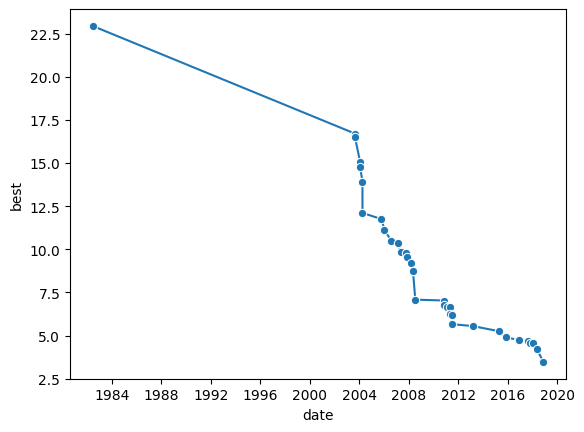

In [13]:
sns.lineplot(data=df_333_singleWRs, y="best", x="date", marker="o")

We can add data point labels to see individual values, but it can get a little bit cluttered.

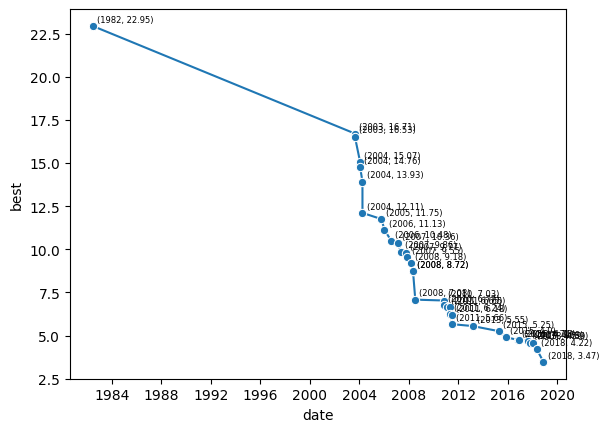

In [14]:
sns.lineplot(data=df_333_singleWRs, y="best", x="date", marker="o")

for date, best in zip(df_333_singleWRs["date"], df_333_singleWRs["best"]):
    label = f"({str(date.year)}, {best})"
    plt.annotate(label, (date, best), xytext=(3,3), textcoords="offset points", fontsize=6)

Let's try to fit a model to the data. Let's start off with a simple linear regression. 

<Axes: xlabel='date', ylabel='best'>

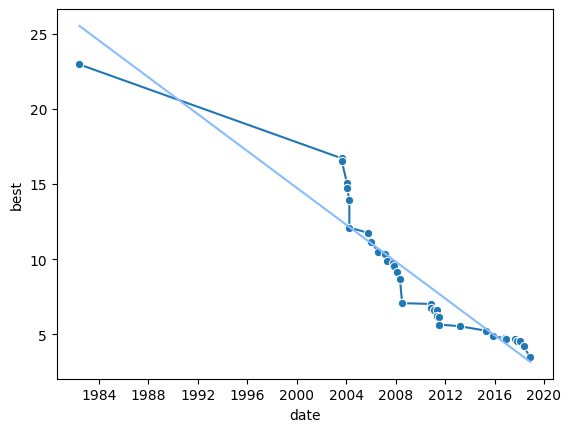

In [14]:
# converting to datetime objects date.ordinals since LinearRegression can not take datetime objects
df_333_singleWRs["ordinal"] = df_333_singleWRs["date"].apply(datetime.date.toordinal)

X = df_333_singleWRs[["ordinal"]]       # df of dates
y = df_333_singleWRs["best"]            # Series of results to match the dates
linreg = LinearRegression().fit(X, y)   # fit the linreg model

linreg_prediction = linreg.predict(X)                       # creating predicted y values using our linreg
df_333_singleWRs["predicted_linreg"] = linreg_prediction    # adding predicted values to our df

# plotting
sns.lineplot(data=df_333_singleWRs, y="best", x="date", marker="o")
sns.lineplot(data=df_333_singleWRs, x="date", y=linreg_prediction, color="#87bdff")

The line looks to fit the downwart trend of the model, but there is a lot of room for improvement. To analyze how well our model fits, lets make a residual plot. 

<Axes: xlabel='ordinal', ylabel='best'>

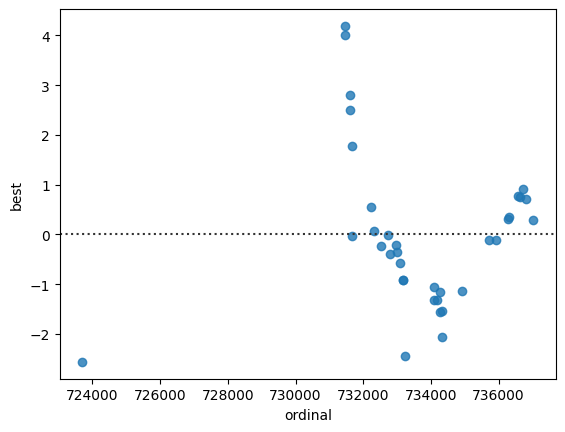

In [30]:
sns.residplot(data=df_333_singleWRs, x="ordinal", y="best")

> Note that ordinal is an integer representation of a `datetime` object (an ordinal represents the date corresponding to the proleptic Gregorian ordinal, where January 1 of year 1 has ordinal 1). Since we are only looking at residuals the human-interpretability of the x-axis labels is not too important.

We can see that this linear regression does not fit too well. A linear regression model has several [assumptions](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/): linearity, homoscedasticity, normality, and independence. A residual plot should show a fairly random pattern, even spread of points, no discernible pattern of increasing or decreasing variability, and a normal distribution of residuals. We can see in our residual plot that there seems to be some sort of pattern, or at the very least the residuals do not seem to be random. We can see residuals being very high above 0 in earlier years, dipping below 0 in the middle years, then going slightly above 0 in later years. The obvious visual explanation to our problem is that the data does not seem to fit along a straight line but rather a curve. Another reason for this pattern in our residual plot could simply be that we do not have that many data points in our model. 

To quantitatively see the accuracy of our model, let's try running an Ordinary Least Squares regression using the `statsmodels` library.

In [25]:
ols_model = sm.ols(formula="best ~ ordinal", data=df_333_singleWRs).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   best   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     227.1
Date:                Fri, 12 May 2023   Prob (F-statistic):           2.36e-16
Time:                        22:51:15   Log-Likelihood:                -65.260
No. Observations:                  35   AIC:                             134.5
Df Residuals:                      33   BIC:                             137.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1239.0797     81.641     15.177      0.0

Notice that the p-value associated with the time (ordinal) coefficient is less than 0.05 (`P>|t| = 0.000`), which indicates that the relationship between time and world record single is statistically significant at the 95% confidence level. This is of course trivially true because over time the world record can only get lower and lower. Later on, we will explore a hypothesis that is not so obviously true. 

Here we see that the R-squared value for our OLS model is `0.873` and our log-likelihood value is `-65.260`. 

Let's try a different model to see if we can get a better fit.

Text(0.5, 0, 'year')

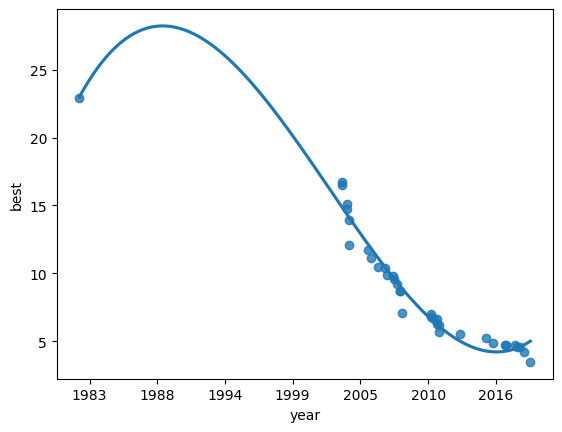

In [49]:
sns.regplot(data=df_333_singleWRs, x="ordinal", y="best", order=3, ci=None)

# changing x-axis tick labels from ordinals to year 
ax = plt.gca()              # get current ax
xticks = ax.get_xticks()    # get xticks
ax.set_xticklabels([datetime.date.fromordinal(int(x)).year for x in xticks])    # convert each ordinal to a year
ax.set_xlabel("year")       # changing x-axis label

Above we are using `seaborn`'s `regplot` with `order=3`, which is a linear regression model fit using a polynomial of order 3. Visually, this appears to fit our data set much better. Let's see how the residual plot looks.

<Axes: xlabel='ordinal', ylabel='best'>

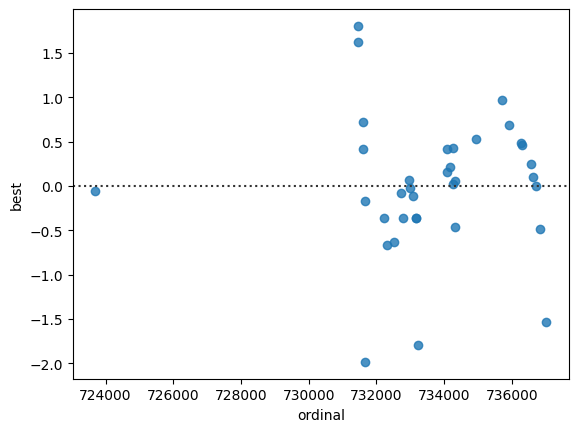

In [50]:
sns.residplot(data=df_333_singleWRs, x="ordinal", y="best", order=3)

Mcuh better! Here we see residuals seemingly randomly scattered, and with more residuals clustered around 0. This indicates a pretty good fit for our linear regression with polynomial terms model! 

If we look back at our polynomial with order 3, we can see how the line curves upwards at the end despite decreasing y-values. How about we change it to order 4?

Text(0.5, 0, 'year')

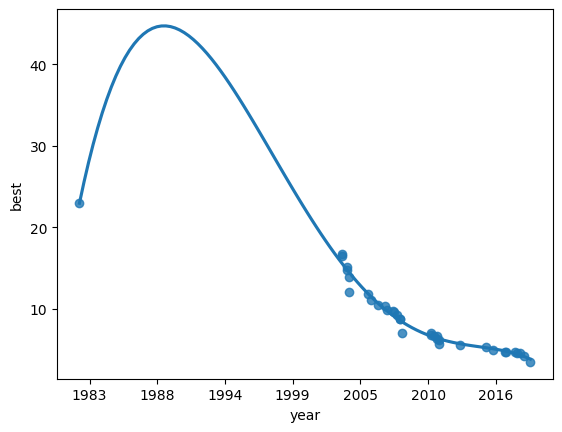

In [59]:
sns.regplot(data=df_333_singleWRs, x="ordinal", y="best", order=4, ci=None)

# changing x-axis tick labels from ordinals to year 
ax = plt.gca()              # get current ax
xticks = ax.get_xticks()    # get xticks
ax.set_xticklabels([datetime.date.fromordinal(int(x)).year for x in xticks])    # convert each ordinal to a year
ax.set_xlabel("year")       # changing x-axis label

<Axes: xlabel='ordinal', ylabel='best'>

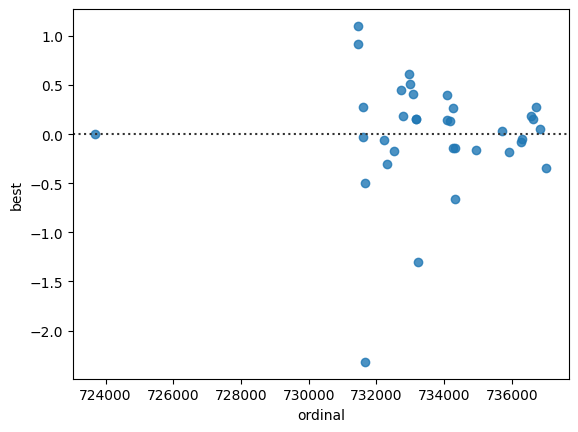

In [58]:
sns.residplot(data=df_333_singleWRs, x="ordinal", y="best", order=4)

The residual plot looks relatively similar.

<Axes: xlabel='date', ylabel='best'>

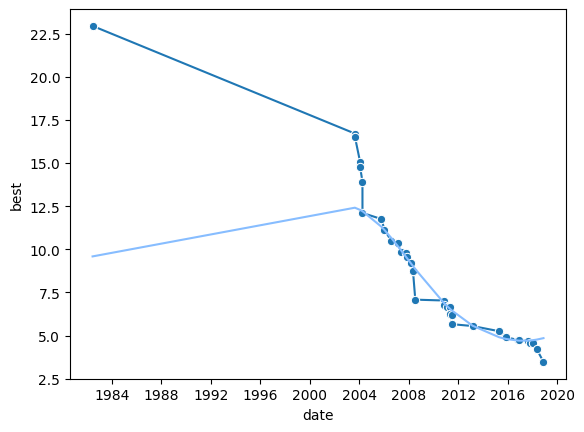

In [257]:
# converting to datetime objects date.ordinals since LinearRegression can not take datetime objects
df_333_singleWRs["ordinal"] = df_333_singleWRs["date"].apply(datetime.date.toordinal)
X = df_333_singleWRs[["ordinal"]]
y = df_333_singleWRs["best"]
linreg = svm.SVR(kernel="rbf").fit(X, y) # fit the linreg model

y_prediction = linreg.predict(X) # creating predicted y values using our linreg
df_333_singleWRs["predicted_svr"] = y_prediction

sns.lineplot(data=df_333_singleWRs, y="best", x="date", marker="o")
sns.lineplot(data=df_333_singleWRs, x="date", y=y_prediction, color="#87bdff")

## Conclusion

We hope the reader has gained new insight into the world of competitive Rubik's Cube solving, learned more about the data science pipeline, and gained more experience with data analysis in Python. Here we have seen several different models for our questions regarding world record changes over time. Although machines can more and more accurately predict the results of our questions, we are constantly still surprised by the real-world results that pop up, often defying all machine-derived expectations (true for cubing and the world in general). Cubing is still a relatively "young" activity and the dataset available to answer many of our questions are still relatively small. It will be interesting to see how the exponential growth of cubing leads to more and more data, and how that data can subsequently impact our models and predictions for the future. 